## Практическое задание к уроку №6

In [137]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np
import matplotlib.pyplot as plt

In [138]:
from sklearn.datasets import load_diabetes

In [139]:
X, y = load_diabetes(return_X_y=True)

In [140]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)

In [141]:
def gb_predict(X, trees_list, eta):
    return np.array(sum([eta * alg.predict(X) for alg in trees_list]))

In [142]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [143]:
def bias(y, z):
    return -(z - y)

In [144]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [145]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, eta):
    train_prediction = gb_predict(X_train, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

1. Для реализованной модели градиентного бустинга постройте графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделайте выводы о зависимости ошибки от этих параметров.

In [146]:
eta = 1

In [147]:
my_n_trees = range(3, 11)

In [148]:
my_max_depth = range(1, 11)

In [149]:
def plot_different_trees(n_trees, max_depth):
    my_train_errors = []
    my_test_errors = []
    
    for n in n_trees:
        i, train_errors, test_errors, = gb_fit(n, max_depth,  X_train, X_test, y_train, y_test, eta)
        my_train_errors.append(train_errors[-1])
        my_test_errors.append(test_errors[-1])
        
    print(f'Максимальная глубина дерева:\t{max_depth}')
    plt.figure(figsize = (16, 7))
    plt.title('График зависимости ошибки от количества деревьев')
    plt.plot(n_trees, my_train_errors, label='train error')
    plt.plot(n_trees, my_test_errors, label='test error')
    plt.xlabel('Кол-во деревьев')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()    

Максимальная глубина дерева:	3


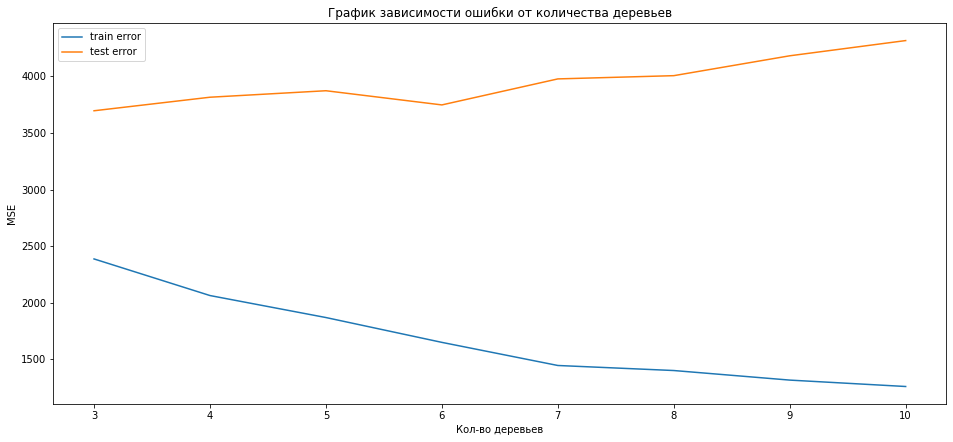

In [150]:
plot_different_trees(n_trees=my_n_trees, max_depth=3)

Максимальная глубина дерева:	5


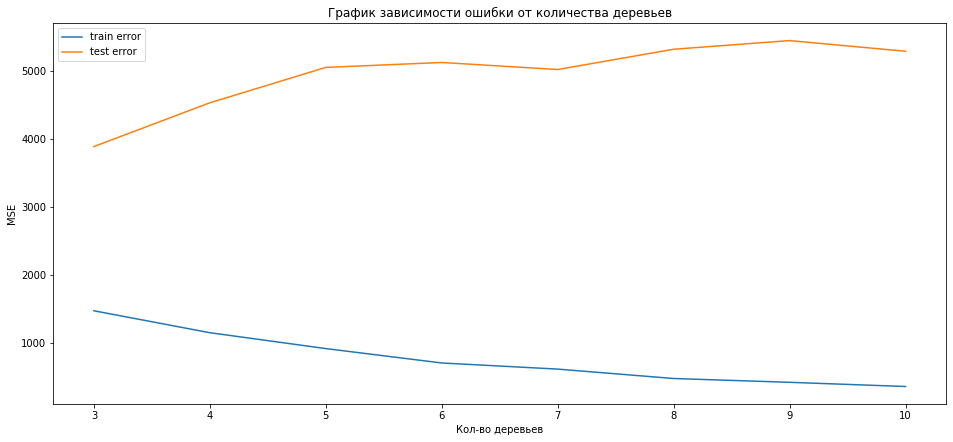

In [151]:
plot_different_trees(n_trees=my_n_trees, max_depth=5)

In [152]:
def plot_different_max_depth(n_trees, max_depth):
    depth_train_errors = []
    depth_test_errors = []
    
    for n in max_depth:
        i, train_errors, test_errors, = gb_fit(n_trees, n,  X_train, X_test, y_train, y_test, eta)
        depth_train_errors.append(train_errors[-1])
        depth_test_errors.append(test_errors[-1])
        
    print(f'Деревьев в бустинге:\t{n_trees}')
    plt.figure(figsize = (16, 7))
    plt.title('График зависимости ошибки от глубины деревьев')
    plt.plot(range(len(max_depth)), depth_train_errors, label='train error')
    plt.plot(range(len(max_depth)), depth_test_errors, label='test error')
    plt.xlabel('Глубина')
    plt.ylabel('MSE')
    plt.legend()
    plt.show() 

Деревьев в бустинге:	3


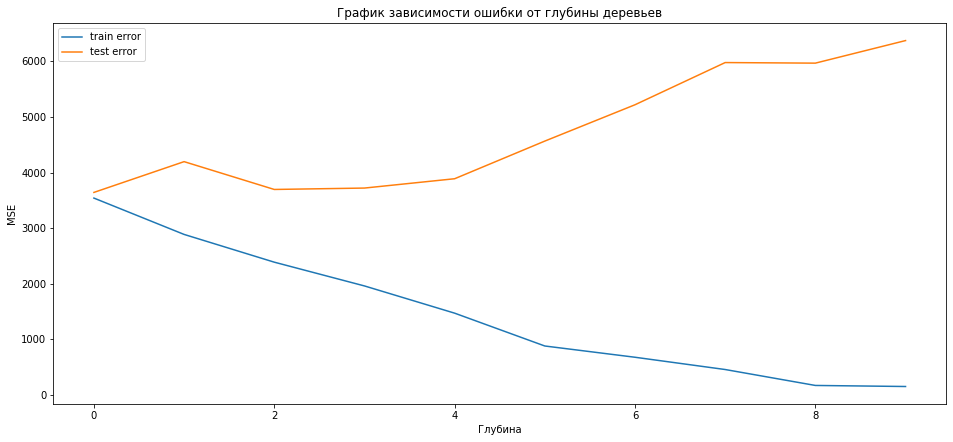

In [153]:
plot_different_max_depth(n_trees=3, max_depth=my_max_depth)

Деревьев в бустинге:	10


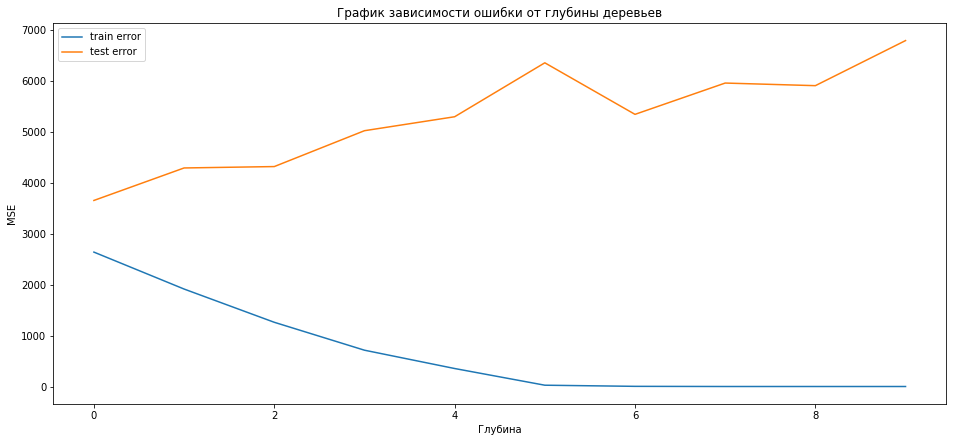

In [154]:
plot_different_max_depth(n_trees=10, max_depth=my_max_depth)

 
2. Модифицируйте реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки примите равным 0.5. Сравните на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [155]:
def stoh_gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta, coeff=0.5):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    data_len = X_train.shape[0]
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        indices = np.random.choice(range(0, data_len), size=int(data_len * coeff), replace=False)
        X_train_part, y_train_part = X_train[indices], y_train[indices]

        
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train_part, y_train_part)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train_part, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train_part, bias(y_train_part, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [156]:
n_trees = 50
max_depth = 3
eta = 0.3

In [157]:
%%time
i, train_err, test_err = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

Wall time: 378 ms


In [158]:
%%time
i, train_err_s, test_err_s = stoh_gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta, coeff=0.5)

Wall time: 328 ms


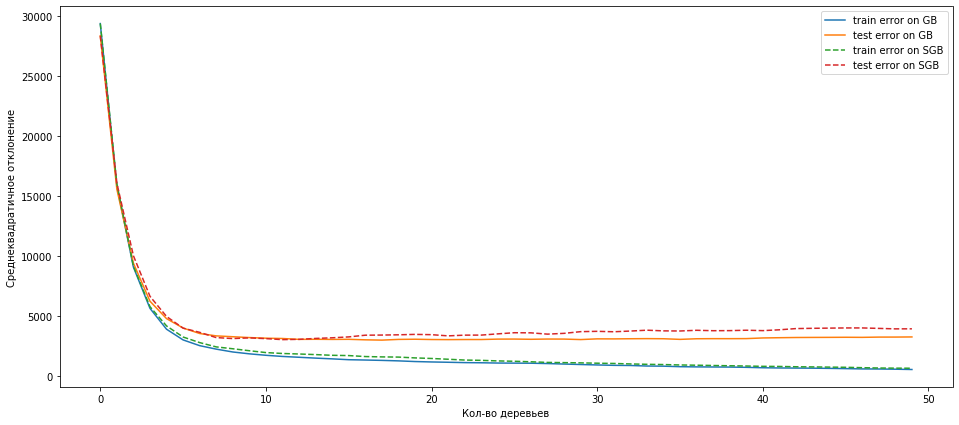

In [160]:
plt.figure(figsize=(16, 7))
plt.plot(range(n_trees), train_err, label='train error on GB')
plt.plot(range(n_trees), test_err, label='test error on GB')
plt.plot(range(n_trees), train_err_s, label='train error on SGB', ls='--')
plt.plot(range(n_trees), test_err_s, label='test error on SGB', ls='--')
plt.xlabel('Кол-во деревьев')
plt.ylabel('Среднеквадратичное отклонение')
plt.legend()
plt.show()